In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import Reader
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
import xgboost as xgb
from collections import defaultdict
from keras.models import load_model
from sklearn.model_selection import train_test_split
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from keras.models import Model
import warnings
from sklearn.manifold import TSNE
import seaborn as sns
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn import datasets

2022-12-07 12:10:00.982189: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Load Data

In [3]:
ratings_path = os.path.join('ml-25m', 'ratings.csv')
movies_path = os.path.join('ml-25m', 'movies.csv')

In [4]:
ratings_data = pd.read_csv(ratings_path)
movies_data = pd.read_csv(movies_path)

In [23]:
ratings_data

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510
...,...,...,...,...
25000090,162541,50872,4.5,1240953372
25000091,162541,55768,2.5,1240951998
25000092,162541,56176,2.0,1240950697
25000093,162541,58559,4.0,1240953434


In [35]:
movies_data

,movieId,title,genres,movieid
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2692
1,2,Jumanji (1995),Adventure|Children|Fantasy,2692
2,3,Grumpier Old Men (1995),Comedy|Romance,2692
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2692
4,5,Father of the Bride Part II (1995),Comedy,2692
...,...,...,...,...
62418,209157,We (2018),Drama,2692
62419,209159,Window of the Soul (2001),Documentary,2692
62420,209163,Bad Poems (2018),Comedy|Drama,2692
62421,209169,A Girl Thing (2001),(no genres listed),2692


#### Preprocessing dataset

In [25]:
ratings_data = ratings_data.dropna()
movies_data = movies_data.dropna()

#### Reduze the lenght of the Movies_data to 50k

In [29]:
ratings_data = ratings_data.head(50000)
ratings_data

,userId,movieId,rating,timestamp
63913,515,1,3.0,1133390093
83229,628,1,4.5,1480626585
83186,627,1,4.0,850527400
29312,226,1,3.0,1059574861
59539,472,1,3.0,984931745
...,...,...,...,...
16671,132,2719,1.0,995848554
68902,548,2719,3.5,1431645045
47273,380,2719,2.0,949272991
62054,494,2719,3.0,1346014362


#### Sort the data by ascendent order of movieId

In [30]:
ratings_data = ratings_data.sort_values(by='movieId', ascending=True)
ratings_data

,userId,movieId,rating,timestamp
63913,515,1,3.0,1133390093
53125,431,1,3.0,1111670920
33848,257,1,4.5,1436899757
34507,265,1,4.0,1176604691
19771,166,1,4.0,942014736
...,...,...,...,...
59865,473,2719,3.0,945568261
22686,177,2719,3.0,935458623
62054,494,2719,3.0,1346014362
22253,175,2719,3.0,992401581


### Mixing Movies and Ranting Dataset

#### The final dataset is stored in a csv file

#### Não corras

In [31]:
genres = []
title = []
aux =[]

all_data = ratings_data
movieRatingInd = ratings_data["movieId"]
movieInd = movies_data["movieId"]
titleInd = movies_data["title"]
genreInd = movies_data["genres"]
all_data_path = os.path.join('ml-25m', 'all_data.csv')

for j in range(len(movieRatingInd)):
    aux = np.where(movieInd == j)
    aux2 = np.where(movieRatingInd == j)
    
    if aux[0].size != 0 and aux2[0].size != 0 :
        for i in range(len(aux2[0])):
            ind = int(aux[0])
            title.append(titleInd[ind])
            genres.append(genreInd[ind])

all_data["title"] = title
all_data["genres"] = genres

all_data = all_data.sort_values(by='userId', ascending=True)
#all_data.to_csv(all_data_path)  
all_data

,userId,movieId,rating,timestamp,title,genres
19,1,2692,5.0,1147869100,Run Lola Run (Lola rennt) (1998),Action|Crime
5,1,1088,4.0,1147868495,Dirty Dancing (1987),Drama|Musical|Romance
7,1,1217,3.5,1147878326,Ran (1985),Drama|War
6,1,1175,3.5,1147868826,Delicatessen (1991),Comedy|Drama|Romance
8,1,1237,5.0,1147868839,"Seventh Seal, The (Sjunde inseglet, Det) (1957)",Drama
...,...,...,...,...,...,...
99791,757,1203,4.0,1184343668,12 Angry Men (1957),Drama
99988,757,2094,3.5,1184074179,"Rocketeer, The (1991)",Action|Adventure|Sci-Fi
99637,757,231,2.0,1184013719,Dumb & Dumber (Dumb and Dumber) (1994),Adventure|Comedy
99705,757,674,4.0,1184346178,Barbarella (1968),Adventure|Comedy|Sci-Fi


### Read the final file

In [2]:
all_data_path = os.path.join('ml-25m', 'all_data.csv')
all_data = pd.read_csv(all_data_path)
all_data=all_data.drop(columns=['Unnamed: 0'])
all_data

,userId,movieId,rating,timestamp,title,genres
0,1,2692,5.0,1147869100,Run Lola Run (Lola rennt) (1998),Action|Crime
1,1,1088,4.0,1147868495,Dirty Dancing (1987),Drama|Musical|Romance
2,1,1217,3.5,1147878326,Ran (1985),Drama|War
3,1,1175,3.5,1147868826,Delicatessen (1991),Comedy|Drama|Romance
4,1,1237,5.0,1147868839,"Seventh Seal, The (Sjunde inseglet, Det) (1957)",Drama
...,...,...,...,...,...,...
49995,757,1203,4.0,1184343668,12 Angry Men (1957),Drama
49996,757,2094,3.5,1184074179,"Rocketeer, The (1991)",Action|Adventure|Sci-Fi
49997,757,231,2.0,1184013719,Dumb & Dumber (Dumb and Dumber) (1994),Adventure|Comedy
49998,757,674,4.0,1184346178,Barbarella (1968),Adventure|Comedy|Sci-Fi


### Using the suprise tool to get information of the recommendation system using Collaborative filtering

#### First will need to create a Matrix Factorization-based Algorithm

##### Matrix factorization algorithms work by decomposing the user-movie interaction matrix into the product of two lower dimensionality rectangular matrices, say U(user matrix) and M(movie matrix).

In [128]:
reader = Reader(rating_scale=(1, 5))

# create the traindata from the data frame
data = Dataset.load_from_df(all_data[['userId', 'movieId', 'rating']], reader)

# build the train set from traindata
trainset = data.build_full_trainset()

svd = SVD() #SVD is a algorithm used for generating synthetic data for Machine Learning tasks
svd.fit(trainset)

##### Getting the RMSE and MAE values

In [129]:
cross_validate(svd,data, measures=['RMSE','MAE'], cv= 5, verbose= True)
print('Training Done')

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8854  0.8904  0.8696  0.8872  0.8858  0.8837  0.0072  
MAE (testset)     0.6867  0.6901  0.6767  0.6906  0.6860  0.6860  0.0050  
Fit time          0.68    0.60    0.62    0.61    0.60    0.62    0.03    
Test time         0.59    0.09    0.14    0.08    0.16    0.21    0.19    
Training Done


##### Now the model is ready,we’ll store these predictions to pass to the final model as an additional feature

In [130]:
train_preds = svd.test(trainset.build_testset())
train_pred_mf = np.array([pred.est for pred in train_preds])

##### Visualize the predicts of the first 20 ratings values

In [131]:
real = np.array([pred.r_ui for pred in train_preds])
pred = np.array([pred.est for pred in train_preds])
print(real,pred)

[5.  4.  3.5 ... 2.  4.  3.5] [4.46756748 3.81150385 4.37545376 ... 2.61016318 3.52535219 3.58006836]


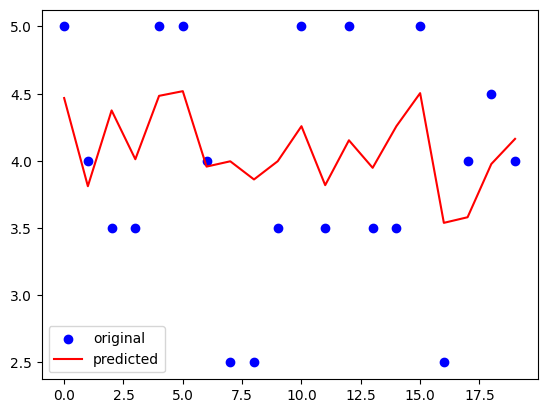

In [132]:
x = list(range(len(real[:20])))
plt.scatter(x,real[:20], color="blue", label="original")
plt.plot(x, pred[:20], color="red", label="predicted")
plt.legend()
plt.show()

##### Visualize the Mean Square Root

In [133]:
data = {'real': real[:20], 'pred': pred[:20]}
df1 = pd.DataFrame(data)
df1

,real,pred
0,5.0,4.467567
1,4.0,3.811504
2,3.5,4.375454
3,3.5,4.012195
4,5.0,4.483862
5,5.0,4.518661
6,4.0,3.957409
7,2.5,3.996900
8,2.5,3.861758
9,3.5,3.997598


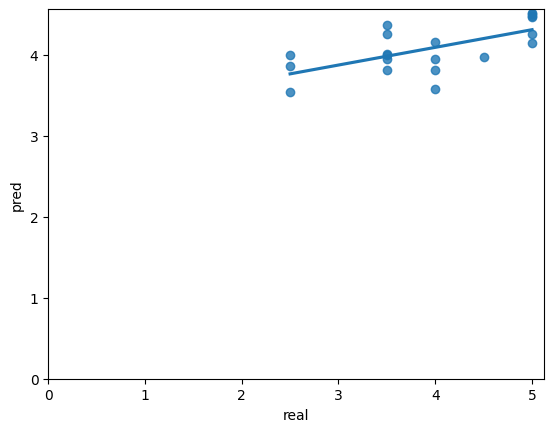

MSE:  0.5068601947547291


In [140]:
sns.regplot(data=df1, x='real', y='pred', ci=None)
plt.ylim(bottom=0)
plt.xlim(left=0)
plt.show()
mse = mean_squared_error(df1['real'], df1['pred'])
print("MSE: ",mse)

#### Creating Handcrafted Features(convert the data in the data frame format into a user-movie interaction matrix.)

In [8]:
# Creating a sparse matrix
train_sparse_matrix = csr_matrix((all_data.rating.values, (all_data.userId.values, all_data.movieId.values)))

##### Get the global average of ratings in our train set.

In [9]:
train_averages = dict()
train_global_average = train_sparse_matrix.sum()/train_sparse_matrix.count_nonzero()
train_averages['global average rating'] = train_global_average
train_averages

{'global average rating': 3.61939}

##### Get the average rating of a movie or user

In [10]:
def get_average_ratings(sparse_matrix, of_users):
    # average ratings of user/axes
    ax = 1 if of_users else 0 # 1 - User axes,0 - Movie axes
    # ".A1" is for converting Column_Matrix to 1-D numpy array
    sum_of_ratings = sparse_matrix.sum(axis=ax).A1
    # Boolean matrix of ratings ( whether a user rated that movie or not)
    is_rated = sparse_matrix!=0
    # no of ratings that each user OR movie
    no_of_ratings = is_rated.sum(axis=ax).A1
    # max_user and max_movie ids in sparse matrix
    u,m = sparse_matrix.shape
    # create a dictionary of users and their average ratings
    average_ratings = { i : sum_of_ratings[i]/no_of_ratings[i]
    for i in range(u if of_users else m)
    if no_of_ratings[i] !=0}
    #return that dictionary(key: user_id/movie_id, value: avg rating)of average ratings
    return average_ratings  

In [11]:
train_averages['user'] = get_average_ratings(train_sparse_matrix, of_users=True)
list(train_averages['user'].values())[0] # Get the avr rating of the user0

3.95

In [12]:
train_averages['movie'] = get_average_ratings(train_sparse_matrix, of_users=False)
list(train_averages['movie'].values())[0] # Get the avr rating of the movie Run Lola Run (Lola rennt) (1998)

3.923694779116466

##### Creating a final model for our movie recommendation system

##### Top 5 recommended movies to all users

In [13]:
def get_top_n(prediction, n):
    
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in prediction:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the n highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n
    
top_n = get_top_n(train_preds, n=5)

for uid, user_ratings in top_n.items():
    print(uid, [all_data['title'].iloc[iid] for (iid, rating) in user_ratings])
    

1 ['Grosse Pointe Blank (1997)', 'Saving Private Ryan (1998)', 'Billy Madison (1995)', 'That Thing You Do! (1996)', 'Pulp Fiction (1994)']
2 ['E.T. the Extra-Terrestrial (1982)', 'Dirty Dancing (1987)', 'Full Metal Jacket (1987)', 'Full Metal Jacket (1987)', 'French Kiss (1995)']
3 ['Little Mermaid, The (1989)', 'Dazed and Confused (1993)', 'Gone with the Wind (1939)', 'Monty Python and the Holy Grail (1975)', 'Twister (1996)']
4 ['That Thing You Do! (1996)', 'Forrest Gump (1994)', 'Ice Storm, The (1997)', 'Gone with the Wind (1939)', 'Heathers (1989)']
5 ['Little Mermaid, The (1989)', 'American Tail, An (1986)', "Mr. Holland's Opus (1995)", 'Willy Wonka & the Chocolate Factory (1971)', 'Dirty Dancing (1987)']
6 ['American Tail, An (1986)', 'Dead Man Walking (1995)', 'Dazed and Confused (1993)', 'E.T. the Extra-Terrestrial (1982)', 'Peacemaker, The (1997)']
7 ['Full Metal Jacket (1987)', 'Pulp Fiction (1994)', 'That Thing You Do! (1996)', "Mr. Holland's Opus (1995)", 'Billy Madison (19

#### Evaluating the system using the MRR

In [24]:
preds = train_preds
revelant = []
for pess in range(1,101):
    query = []
    for uid, iid, true_r, est, _  in preds:
        if uid == pess:
            query.append(iid)
    query.sort()
    revelant.append(query)
revelant

[[296,
  306,
  307,
  665,
  899,
  1088,
  1175,
  1217,
  1237,
  1250,
  1260,
  1653,
  2011,
  2012,
  2068,
  2161,
  2351,
  2573,
  2632,
  2692],
 [1,
  62,
  110,
  150,
  151,
  236,
  260,
  261,
  266,
  318,
  333,
  349,
  356,
  364,
  380,
  457,
  480,
  497,
  524,
  527,
  534,
  553,
  588,
  589,
  653,
  733,
  858,
  914,
  953,
  1035,
  1080,
  1136,
  1196,
  1197,
  1198,
  1201,
  1210,
  1246,
  1257,
  1270,
  1271,
  1275,
  1283,
  1287,
  1291,
  1293,
  1299,
  1302,
  1356,
  1374,
  1376,
  1393,
  1431,
  1465,
  1485,
  1488,
  1527,
  1580,
  1584,
  1587,
  1610,
  1653,
  1672,
  1674,
  1682,
  1693,
  1722,
  1873,
  1907,
  1923,
  1957,
  1968,
  2028,
  2081,
  2083,
  2115,
  2138,
  2139,
  2150,
  2194,
  2268,
  2273,
  2294,
  2324,
  2355,
  2359,
  2406,
  2470,
  2496,
  2501,
  2571,
  2617,
  2640,
  2643,
  2694],
 [1,
  29,
  32,
  50,
  111,
  172,
  173,
  214,
  260,
  293,
  296,
  318,
  356,
  442,
  480,
  527,
  541,
 

In [26]:
Q = len(revelant)

reciprocal = 0
for i in range(Q):
    res = revelant[i][0]
    reciprocal = reciprocal + (1/res)
    print(f"Query {i+1} = 1/{res} = {reciprocal} ")

mrr = 1/Q * reciprocal
print("MRR = ", mrr)

Query 1 = 1/296 = 0.0033783783783783786 
Query 2 = 1/1 = 1.0033783783783783 
Query 3 = 1/1 = 2.003378378378378 
Query 4 = 1/1 = 3.003378378378378 
Query 5 = 1/1 = 4.003378378378378 
Query 6 = 1/161 = 4.009589558502602 
Query 7 = 1/10 = 4.109589558502601 
Query 8 = 1/1 = 5.109589558502601 
Query 9 = 1/2 = 5.609589558502601 
Query 10 = 1/1 = 6.609589558502601 
Query 11 = 1/277 = 6.61319966680585 
Query 12 = 1/1 = 7.61319966680585 
Query 13 = 1/1 = 8.613199666805851 
Query 14 = 1/50 = 8.63319966680585 
Query 15 = 1/110 = 8.64229057589676 
Query 16 = 1/318 = 8.64543522998481 
Query 17 = 1/588 = 8.64713591025692 
Query 18 = 1/1 = 9.64713591025692 
Query 19 = 1/2 = 10.14713591025692 
Query 20 = 1/2 = 10.64713591025692 
Query 21 = 1/260 = 10.650982064103074 
Query 22 = 1/150 = 10.65764873076974 
Query 23 = 1/3 = 10.990982064103074 
Query 24 = 1/31 = 11.023240128619204 
Query 25 = 1/16 = 11.085740128619204 
Query 26 = 1/1 = 12.085740128619204 
Query 27 = 1/110 = 12.094831037710113 
Query 28 = 

### Recomendation System using Content-based filtering with Cosine algorithm

In [3]:
all_data['genres'] = list(map(lambda x: x.replace('|', ' '), all_data['genres']))
all_data['genres']

0                   Action Crime
1          Drama Musical Romance
2                      Drama War
3           Comedy Drama Romance
4                          Drama
                  ...           
49995                      Drama
49996    Action Adventure Sci-Fi
49997           Adventure Comedy
49998    Adventure Comedy Sci-Fi
49999                Documentary
Name: genres, Length: 50000, dtype: object

##### Creating the TF-IDF Matrix, we digitized the overview so we can calculate the similarity beetween the words

In [12]:
tf = TfidfVectorizer()
all_data['genres'] = all_data['genres'].fillna('')
tfidf_matrix = tf.fit_transform(all_data['genres'])
tfidf_matrix.shape

(50000, 21)

In [14]:
tf2 = TfidfVectorizer()
all_data['title'] = all_data['title'].fillna('')
tfidf_matrix2 = tf2.fit_transform(all_data['title'])
tfidf_matrix2.shape

(50000, 2796)

##### Creating the Cosine Similarity Matrix

In [5]:
cosine_sin = cosine_similarity(tfidf_matrix,tfidf_matrix)
cosine_sin.shape

(50000, 50000)

In [18]:
cosine_sin2 = cosine_similarity(tfidf_matrix2,tfidf_matrix2)
cosine_sin2.shape

(50000, 50000)

##### Making Suggestions Based on Similarities

In [29]:
#Catches the indexes of all the movies
indices = pd.Series(all_data.index, index=all_data['title'])
indices.head()

title
Run Lola Run (Lola rennt) (1998)                   0
Dirty Dancing (1987)                               1
Ran (1985)                                         2
Delicatessen (1991)                                3
Seventh Seal, The (Sjunde inseglet, Det) (1957)    4
dtype: int64

In [30]:
#Delete to duplicated ones.
indices = indices[~indices.index.duplicated(keep='last')]
indices.shape

(2020,)

In [31]:
def recomended_movies(movie_title,cosine_sin = cosine_sin, cosine_sin2 = cosine_sin2):
   
   index = indices[movie_title]
   #enumerates the cosine_sin with the index (index,consine_sin)
   cosine_sin = cosine_sin*0.7
   cosine_sin2 = cosine_sin2*0.3
   cosine_total = np.add(cosine_sin, cosine_sin2)

   #sin_socre_total = enumerate(consine_total[index])
   
   #sin_score = enumerate(cosine_sin[index])
   #sin_score2 = enumerate(cosine_sin2[index]) 
   sin_total = enumerate(cosine_total[index]) 
   #sortes the consine_sin value by ascendent order
   sin_total = sorted(sin_total,key = lambda x:x[1],reverse=True) 
   #gets the top 10 movies
   sin_total = sin_total[1:6] 
   sin_index = [i[0] for i in sin_total]
   print(all_data['title'].iloc[sin_index])
   
recomended_movies('Delicatessen (1991)')

1029    Delicatessen (1991)
3723    Delicatessen (1991)
5374    Delicatessen (1991)
6134    Delicatessen (1991)
7046    Delicatessen (1991)
Name: title, dtype: object


##### Get the top 3 movies of an user to make recommendation based on these movies

In [9]:
def get_movies(userId):
    movies = []
    ind = np.where(all_data["userId"]==userId)
    for i in range(3):
        movies.append(all_data["title"][ind[0][i]])

    return movies

In [13]:
get_movies(8)

['Stargate (1994)', 'Wedding Singer, The (1998)', 'Sabrina (1995)']

In [14]:
def get_recomendation(userId):
    movies = get_movies(userId)
    for i in range(len(movies)):
        print("Because you watched "+movies[i]+",we recommend the follow:")
        recomended_movies(movies[i])
        print("\n")

In [15]:
get_recomendation(8)

Because you watched Stargate (1994),we recommend the follow:
24             Star Wars: Episode IV - A New Hope (1977)
54               Superman IV: The Quest for Peace (1987)
77     Star Wars: Episode V - The Empire Strikes Back...
83     Star Wars: Episode VI - Return of the Jedi (1983)
116     Star Wars: Episode I - The Phantom Menace (1999)
Name: title, dtype: object [(24, 1.0), (54, 1.0), (77, 1.0), (83, 1.0), (116, 1.0)]


Because you watched Wedding Singer, The (1998),we recommend the follow:
89     There's Something About Mary (1998)
100             Blast from the Past (1999)
109              Better Off Dead... (1985)
221                       Boomerang (1992)
272                            Dave (1993)
Name: title, dtype: object [(89, 1.0), (100, 1.0), (109, 1.0), (221, 1.0), (272, 1.0)]


Because you watched Sabrina (1995),we recommend the follow:
89     There's Something About Mary (1998)
100             Blast from the Past (1999)
109              Better Off Dead... (1985)
221

### Colaborative-based Recommendation System using Keras

#### Keras is a deep learning API written in Python

In [141]:
keras_data = all_data
id = np.array([i+1 for i in range(len(keras_data))])
keras_data['Id'] = id
#to change the colun id to the first column
first_column = keras_data.pop('Id')
keras_data.insert(0, 'Id', first_column)

keras_data.head()

,Id,userId,movieId,rating,timestamp,title,genres
0,1,1,2692,5.0,1147869100,Run Lola Run (Lola rennt) (1998),Action|Crime
1,2,1,1088,4.0,1147868495,Dirty Dancing (1987),Drama|Musical|Romance
2,3,1,1217,3.5,1147878326,Ran (1985),Drama|War
3,4,1,1175,3.5,1147868826,Delicatessen (1991),Comedy|Drama|Romance
4,5,1,1237,5.0,1147868839,"Seventh Seal, The (Sjunde inseglet, Det) (1957)",Drama


##### Split it into a test and train dataset 20% of the dataset is considered as a test, and the rest 80% is considered as a training dataset. Training neural network requires a large amount of data for better accuracy.

In [142]:
train, test = train_test_split(keras_data, test_size=0.2, random_state=42)

#### Create neural network model

##### The model consists of 3 layers: Input Layer, Embedding Layer, Output Layer 

In [144]:
# creating movie embedding path
n_items = len(keras_data['movieId'])
n_users = len(keras_data['userId'])
movie_input = Input(shape=[1], name="Movie-Input")
movie_embedding = Embedding(n_items+1, 5, name="Movie-Embedding")(movie_input)
movie_vec = Flatten(name="Flatten-Movies")(movie_embedding)
# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)
# concatenate features
conc = Concatenate()([movie_vec, user_vec])
# add fully-connected-layers
fc1 = Dense(128, activation='relu')(conc)
fc2 = Dense(32, activation='relu')(fc1)
out = Dense(1)(fc2)
# Create model and compile it
model2 = Model([user_input, movie_input], out)
model2.compile('adam', 'mean_squared_error')

model2.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Movie-Input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 User-Input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 Movie-Embedding (Embedding)    (None, 1, 5)         250005      ['Movie-Input[0][0]']            
                                                                                                  
 User-Embedding (Embedding)     (None, 1, 5)         250005      ['User-Input[0][0]']             
                                                                                            

#### Train Model


In [145]:
history = model2.fit([train.userId, train.movieId], train.rating, epochs=10, verbose=1)

Epoch 1/10
1250/1250 [==============================] - 6s 4ms/step - loss: 1.2111
Epoch 2/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.7484
Epoch 3/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.7164
Epoch 4/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.6969
Epoch 5/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.6843
Epoch 6/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.6738
Epoch 7/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.6619
Epoch 8/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.6486
Epoch 9/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.6363
Epoch 10/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.6221


#### Plot training loss

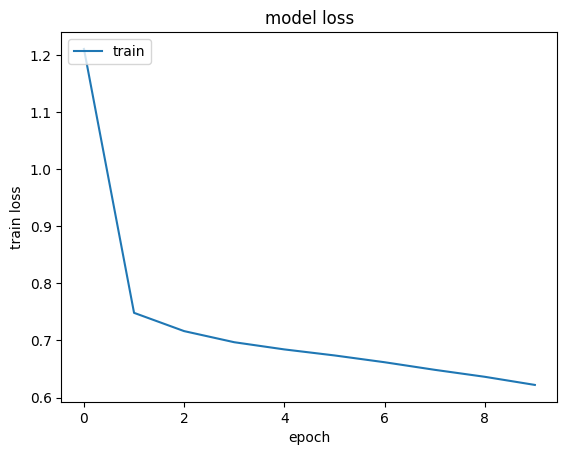

In [146]:
plt.plot(history.history["loss"])
plt.title("model loss")
plt.ylabel("train loss")
plt.xlabel("epoch")
plt.legend(["train"], loc="upper left")
plt.show()

#### Visualizing the embeddings

##### To visualize these concepts, we need to reduce dimensionality further using dimensionality reduction techniques like t-distributed stochastic neighbor embedding (TSNE)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 50001 samples in 0.057s...
[t-SNE] Computed neighbors for 50001 samples in 6.366s...
[t-SNE] Computed conditional probabilities for sample 1000 / 50001
[t-SNE] Computed conditional probabilities for sample 2000 / 50001
[t-SNE] Computed conditional probabilities for sample 3000 / 50001
[t-SNE] Computed conditional probabilities for sample 4000 / 50001
[t-SNE] Computed conditional probabilities for sample 5000 / 50001
[t-SNE] Computed conditional probabilities for sample 6000 / 50001
[t-SNE] Computed conditional probabilities for sample 7000 / 50001
[t-SNE] Computed conditional probabilities for sample 8000 / 50001
[t-SNE] Computed conditional probabilities for sample 9000 / 50001
[t-SNE] Computed conditional probabilities for sample 10000 / 50001
[t-SNE] Computed conditional probabilities for sample 11000 / 50001
[t-SNE] Computed conditional probabilities for sample 12000 / 50001
[t-SNE] Computed conditional probabilities for sa

<AxesSubplot: >

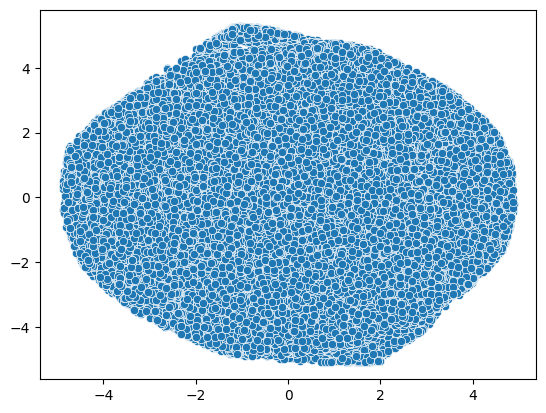

In [34]:
# Extract embeddings
movies_em = model2.get_layer('Movie-Embedding')
movies_em_weights = movies_em.get_weights()[0]

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tnse_results = tsne.fit_transform(movies_em_weights)
sns.scatterplot(x=tnse_results[:,0], y=tnse_results[:,1])

#### Make Predictions

##### Here we are see the accuracy of predicting the rating from the test dataset and predicted values for corresponding user_id and movie_id

In [147]:
predictions = model2.predict([test.userId, test.movieId])
[ print(predictions[i], test.rating.iloc[i]) for i in range(0,10)]
mae = mean_squared_error(test.rating, predictions)
mse = mean_squared_error(test.rating, predictions)
rmse = np.sqrt(mse) 
print("MAE: ",mae)
print("MSE:",mse)
print("RMSE: ",rmse)

313/313 [==============================] - 1s 1ms/step
[4.4585266] 4.0
[4.135089] 4.0
[3.4868011] 3.0
[4.0772276] 5.0
[3.096655] 3.0
[4.141476] 4.0
[4.0273314] 4.0
[3.2158527] 5.0
[4.2517858] 1.0
[3.711598] 3.0
MAE:  0.7787979253817626
MSE: 0.7787979253817626
RMSE:  0.8824952834898114


##### Visualize the real and predictions values of ratings of the first 20 people

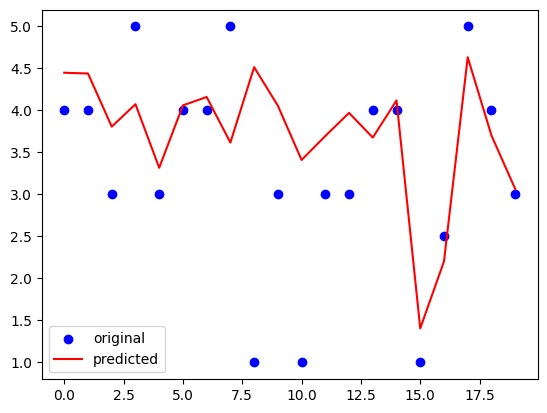

In [91]:
real = np.array([test.rating.head(20)])
pred = np.array([predictions[i] for i in range(20)])
x = list(range(len(real[0])))
plt.scatter(x,real, color="blue", label="original")
plt.plot(x, pred, color="red", label="predicted")
plt.legend()
plt.show() 

##### Viasualize the Mean Square error

In [115]:
r = test.rating.head(20)
data = {'real': r, 'pred': [predictions[i] for i in range(20)]}
df = pd.DataFrame(data)
df

,real,pred
33553,4.0,[4.4493484]
9427,4.0,[4.440026]
199,3.0,[3.807703]
12447,5.0,[4.0744643]
39489,3.0,[3.3175573]
42724,4.0,[4.060812]
10822,4.0,[4.1605015]
49498,5.0,[3.6178951]
4144,1.0,[4.5156684]
36958,3.0,[4.056967]


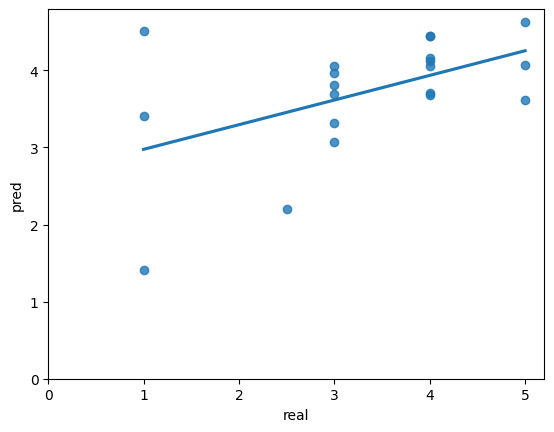

In [116]:
sns.regplot(data=df, x='real', y='pred', ci=None)
plt.ylim(bottom=0)
plt.xlim(left=0)
plt.show()

#### Make the predictions for the recommend movies

##### Making recommendations using our trained model is simple. We only need to feed in a user and all movies and then select the movies which have the highest predicted ratings for that specific user.

In [88]:
# Creating dataset for making recommendations for the first user
movie_data = np.array(list(set(keras_data['movieId'])))
user = np.array([0 for i in range(len(movie_data))]) # creates a movie array with the size of the movie_data filled with 0 to get the fisrt user that has the 0 index 
predictions = model2.predict([user, movie_data])
predictions = np.array([a[0] for a in predictions])
recommended_movies_ids = (-predictions).argsort()[:5] # the -predction gives the best predicts and [:5] gives the first five
print(recommended_movies_ids)

64/64 [==============================] - 0s 3ms/step
[ 743 1147 1132  706  347]


In [38]:
print(keras_data[keras_data['Id'].isin(recommended_movies_ids)])

        Id  userId  movieId  rating   timestamp  \
346    347       7      527     5.0   835444989   
705    706      10      296     4.5  1227571308   
742    743      12     1760     3.5  1119355430   
1131  1132      12      858     4.0   940873638   
1146  1147      13     2046     3.0  1237969685   

                               title                       genres  
346          Schindler's List (1993)                    Drama|War  
705              Pulp Fiction (1994)  Comedy|Crime|Drama|Thriller  
742               Spice World (1997)                       Comedy  
1131           Godfather, The (1972)                  Crime|Drama  
1146  Flight of the Navigator (1986)    Adventure|Children|Sci-Fi  


#### Evaluating the dataset using MRR with 100 queries(users)

In [68]:
data = []
pess = []
for i in range(len(keras_data)):
    if keras_data["userId"][i] in pess:
        continue
    elif len(pess) == 100:
        break
    else:
        pess.append(keras_data["userId"][i])
        data.append(i)
print(data)

[0, 20, 115, 181, 214, 315, 339, 364, 519, 696, 729, 738, 1141, 1250, 1259, 1313, 1323, 1324, 1456, 1542, 1581, 1593, 1615, 1949, 1964, 2051, 2079, 2122, 2164, 2181, 2195, 2371, 2404, 2420, 2442, 2458, 2565, 2583, 2629, 2646, 2693, 2863, 2881, 3083, 3087, 3131, 3199, 3268, 3293, 3318, 3354, 3363, 3374, 3387, 3409, 3424, 3443, 3547, 3621, 3804, 3842, 4088, 4126, 4127, 4144, 4145, 4190, 4297, 4304, 4377, 4484, 4502, 5100, 5139, 5161, 5362, 5413, 5458, 5472, 5494, 5825, 5840, 5878, 5896, 5970, 6038, 6160, 6180, 6190, 6335, 6368, 6384, 6429, 6445, 6498, 6552, 6557, 6602, 6637, 6685]


In [74]:
revelant_results = []
for num in data:   
    movie_data = np.array(list(set(keras_data['movieId'])))
    user = np.array([num for i in range(len(movie_data))]) # creates a movie array with the size of the movie_data filled with 1 
    predictions = model2.predict([user, movie_data])
    predictions = np.array([a[0] for a in predictions])
    recommended_movies_ids = (-predictions).argsort()[:5]
    recommended_movies_ids.sort()
    revelant_results.append(recommended_movies_ids)


64/64 [==============================] - 0s 3ms/step


[array([ 347,  706,  743, 1132, 1147]),
 array([ 347,  706,  743,  861, 1132]),
 array([ 501,  701,  706,  743, 1147]),
 array([ 743,  918,  936, 1132, 1907]),
 array([ 347,  701,  706,  743, 1147]),
 array([ 347,  706,  743, 1132, 1337]),
 array([ 104,  706,  743,  771, 1973]),
 array([ 347,  706,  743, 1132, 1337]),
 array([ 347,  706,  743, 1132, 1147]),
 array([ 104,  347,  706,  743, 1147]),
 array([ 501,  701,  706,  743, 1147]),
 array([  39,  743, 1132, 1392, 1907]),
 array([ 347,  706,  743, 1132, 1147]),
 array([ 347,  706,  743, 1132, 1147]),
 array([ 347,  706,  743, 1132, 1147]),
 array([ 347,  706,  743, 1132, 1147]),
 array([ 347,  706,  743, 1132, 1147]),
 array([ 347,  706,  743, 1132, 1147]),
 array([ 347,  706,  743, 1132, 1147]),
 array([ 347,  706,  743, 1132, 1147]),
 array([ 347,  706,  743, 1132, 1147]),
 array([ 347,  706,  743, 1132, 1147]),
 array([ 347,  706,  743, 1132, 1147]),
 array([ 347,  706,  743, 1132, 1147]),
 array([ 347,  706,  743, 1132, 1147]),


In [89]:
Q = len(revelant_results)

reciprocal = 0
for i in range(Q):
    res = revelant_results[i][0]
    reciprocal = reciprocal + (1/res)
    #print(f"Query {i+1} = 1/{res} = {reciprocal} ")

mrr = 1/Q * reciprocal
print("MRR = ", mrr)

MRR =  0.0037976523678445373
